# Imports, function definitions and assumptions

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import latex

sp.init_printing(use_latex = True)

def sind(angle):
    angle_radians = angle * math.pi/ 180
    result = math.sin(angle_radians)
    return(result)

def cosd(angle):
    angle_radians = angle * math.pi/ 180
    result = math.cos(angle_radians)
    return(result)

'''Assumptions'''
shop_air_pressure = 90 # psi
metric_shop_air = shop_air_pressure * 0.00689476 # MPa (N/mm^2)
generic_actuator_mass = 2.1 # kg; not all actuators have mass properties in the model

gripper_mass = generic_actuator_mass
cross_car_pusher_mass = generic_actuator_mass

gripper_size = 40 # 'radius' of gripper
cross_car_pusher_size = 40 # 'radius' of cross car actuator

cross_car_actuation_time = 1 # second
PtoD_time = 20 # seconds
# Total cycle time for existing equipment is approximately 5 minutes.

'''Requirements from the print'''
LAP = 200 # mm approximate LAP in vehicle for which efforts are developed.
unlock_angle = 8 # deg

Peak_effort = 26.1 # N 
Cross_car_effort = 11.7 # N (7.7 +/- 4) @LAP


# Symbol definitions for symbolic math

This is required so that a function for the desired acceleration profile can be integrated to produce the velocity and position profiles

In [2]:
t, theta, omega, alpha = sp.symbols('t theta omega alpha')

magnitude = 1
final_position = 0 # initialize this variable to 0. The loop will attempt to match this to the target position
target_position = 30
delta = math.inf
#for i in range(500):
while abs(delta) > 0.1:
    alpha_expr = magnitude*(t)*(t-PtoD_time/2)*(t-PtoD_time)
    omega_expr = sp.integrate(alpha_expr,t)
    theta_expr = sp.integrate(omega_expr,t)

    final_position = theta_expr.subs(t,PtoD_time)
    
    delta = (target_position-final_position)
    magnitude += delta*0.000001
    
print("Final position: ",final_position)
acc_equation = (sp.pretty(alpha)) + " = " + sp.pretty(alpha_expr)
vel_equation = sp.pretty(omega) + " = " + sp.pretty(omega_expr)
pos_equation = sp.pretty(theta) + " = " + sp.pretty(theta_expr)

sp.pprint(acc_equation)
sp.pprint(vel_equation)
sp.pprint(pos_equation)

Final position:  30.0978586367428
α = 0.00112866969887786⋅t⋅(t - 20)⋅(t - 10.0)
ω =                       4                       3                      2
  0.000282167424719465⋅t  - 0.0112866969887786⋅t  + 0.112866969887786⋅t   
θ =                      5                        4                       3
  5.64334849438929e-5⋅t  - 0.00282167424719465⋅t  + 0.0376223232959286⋅t   


# Measurements from the model

Certain measurements were taken from the CAD model of the parametric stand in order to determine the mass properties of the tooling being analyzed. Several of the actuators did not have mass properties, so their moments of inertia were found using an estimated mass and treating them as cylinders roughly matching the actuator size.

In [3]:
'''Measurements from the model'''
tooling_mass = 1.97951 # kg
tooling_com_r = 95.55 # mm
# With the lever in the park position, this is the angle between a vertical reference and the centerline upon which the COM lies.
tooling_com_angle = 61
fan_angle = 30 # resulting in COM 91 degrees from vertical with the lever in Drive.

LAP_r = 157.65 # mm This is the distance where the parametric tooling is pushing on the lever simulator from the shaft
cross_car_r = 64.6 # mm This is the location of the cross-car actuator from the shaft

Cross_car_actuator_force = Cross_car_effort*LAP/cross_car_r

print("Required cross car actuator force (static): {:4.2f} N".format(Cross_car_actuator_force))

cross_car_stroke_chord = sind(unlock_angle)*cross_car_r/sind(90-unlock_angle/2)
print("Cross-car stroke {:4.2f} mm".format(cross_car_stroke_chord))

ForeAft_max_torque = Peak_effort * LAP_r
print("Max static torque {:4.2f} Nmm\n".format(ForeAft_max_torque))
gear_ratio = 100/1

Required cross car actuator force (static): 36.22 N
Cross-car stroke 9.01 mm
Max static torque 4114.66 Nmm



# Inertia calculations

The following line calculate the moment of inertia of several items about an axis through their own center of mass (COM) and
parallel to the rotating shaft, uses the parallel axis theorem shown below to find their respective moments of inertia about
the shaft, then adds them to get the effective moment of inertia of the tooling.

$I_{shaft} = I_{COM} + m*d^2$

where d is the distance between two parallel axes and m is the mass of the object in question

In [4]:
# Actuators modeled as solid cylinders where mass properties are unavailable.
I_gripper = 0.5*gripper_mass*gripper_size**2
I_cross_car_pusher = 0.5*cross_car_pusher_mass*cross_car_pusher_size**2

# Parallel axis theorem to sum moments of inertia about COM
I_gripper_COM = I_gripper + gripper_mass * LAP_r**2
I_cross_car_pusher_COM = I_cross_car_pusher + cross_car_pusher_mass * cross_car_r**2

Itooling = 25762.28127 # kg/mm^2 from the model
I = I_gripper_COM + Itooling + I_cross_car_pusher_COM


The following generates data point based on the equations determined above for the purpose of plotting the angular position, velocity and acceleration of the tooling

In [5]:
'''Motion profile'''
dt = 0.05
time_data = np.arange(0.0,PtoD_time+dt,dt)
time_data = time_data.tolist()
theta_list = []
omega_list = []
alpha_list = []
angle_offset = []

for second in time_data:
    theta_list.append(theta_expr.subs(t,second))
    omega_list.append(omega_expr.subs(t,second)*gear_ratio)
    alpha_list.append(alpha_expr.subs(t,second))
    angle_offset.append(theta_expr.subs(t,second)+tooling_com_angle)

max_velocity = omega_expr.subs(t,PtoD_time/2)
max_acceleration = max(alpha_list)

print("Final position = {:4.2f}".format(final_position))
print("Maximum velocity = {:4.2f}".format(max_velocity))
print("Maximum acceleration = {:4.2f}".format(max_acceleration))


print("Moment of inertia about the shaft {:4.2f} kg/mm^2".format(I))

Final position = 30.10
Maximum velocity = 2.82
Maximum acceleration = 0.43
Moment of inertia about the shaft 90078.31 kg/mm^2


# Determine the net torque based on the motion profile

The following uses the relationship below to determine the required net torque on the assembly.

$I*{\alpha} = {\sum}T$

In [6]:
net_torque_list = []
for i, t in enumerate(time_data):
    try:
        temp_torque = (I*float(alpha_list[i]))/1000 # Nm
    except ZeroDivisionError:
        temp_torque = 0
        
    net_torque_list.append(temp_torque)
    #print("Time: {:4.2f}, Alpha = {:4.2f}, Torque = {:4.2f}".format(t, float(alpha_list[i]),temp_torque))
    
net_torque = [time_data,net_torque_list]

position = [time_data,theta_list]
velocity = [time_data,omega_list]
acceleration = [time_data,alpha_list]


#torque_axis = plt.subplot2grid((1,2),(0,1),rowspan=1,colspan=1)

# The following creates a subplot with the motion profile data that will be plotted below
#motion_axis = plt.subplot2grid((1,2),(0,0),rowspan=1,colspan=1)


In [7]:

'''Actuator specs'''
max_net_torque = I*max_acceleration/1000 # N*m
print("Maximum net torque {:4.2f} Nm".format(max_net_torque))


Maximum net torque 39.13 Nm


# Determine the torque caused by the fixture mass


In [8]:
tooling_torque_list = []
for angle in theta_list:
    Phi = tooling_com_angle + angle
    temp_torque = 9.81*(tooling_mass+gripper_mass+cross_car_pusher_mass)*sind(Phi)
    tooling_torque_list.append(temp_torque)
tooling_torque = [time_data,tooling_torque_list]
# This torque is a function of the lever angle. If not sharing an axis with theta this is not valid

# Determine the torque caused by the detent profile

# Determine the required torque from the motor

In [13]:
motor_torque_list = []
for i, torque in enumerate(net_torque_list):
    #temp_torque = torque - tooling_torque_list[i] - detent_torque_list[i]
    temp_torque = torque - tooling_torque_list[i]
    motor_torque_list.append(temp_torque/gear_ratio)
motor_torque = [time_data,motor_torque_list]

# convert to oz-in for comparison to data sheet
english_motor_torque = []
speed_rps = []
for t in motor_torque_list:
    english_motor_torque.append(abs(t*141.612))
for s in omega_list:
    # From deg/s to rps
    speed_rps.append(s/360)

torque_by_speed = [speed_rps, english_motor_torque]

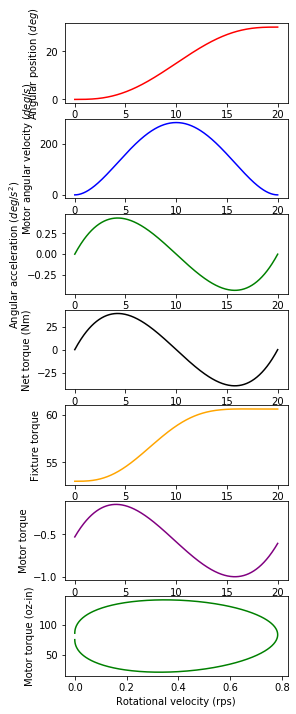

In [14]:
Figure, axes = plt.subplots(7,1,figsize=(4,12))
axes[0].set_ylabel("Angular position ($deg$)")
axes[0].plot(position[0],position[1],'r-')

axes[1].set_ylabel("Motor angular velocity ($deg/s$)")
axes[1].plot(velocity[0],velocity[1],'b-')

axes[2].set_ylabel("Angular acceleration ($deg/s^2$)")
axes[2].plot(acceleration[0],acceleration[1],'g-')

axes[3].set_ylabel("Net torque (Nm)")
axes[3].plot(net_torque[0],net_torque[1],'k-')

axes[4].set_ylabel("Fixture torque")
axes[4].plot(tooling_torque[0],tooling_torque[1],'orange')

axes[5].set_ylabel("Motor torque")
axes[5].plot(motor_torque[0],motor_torque[1],'purple')

axes[6].set_ylabel("Motor torque (oz-in)")
axes[6].set_xlabel("Rotational velocity (rps)")
axes[6].plot(torque_by_speed[0],torque_by_speed[1],'green')

plt.show()

In [25]:
print(max(max(motor_torque_list), min(motor_torque_list)*-1))
print(max(max(net_torque_list), min(net_torque_list)*-1))

0.9974480654575325
39.13131567787603
